### [Build a Chatbot](https://python.langchain.com/docs/tutorials/chatbot/)

In [1]:
import getpass
import os

if "LANGCHAIN_API_KEY" not in os.environ:
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

In [2]:
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass()

#### A. Quickstart

In [3]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")

In [4]:
from langchain_core.messages import HumanMessage

print(model.invoke([HumanMessage("Hola! Soy Nahum")]))
print(model.invoke([HumanMessage("Cual es mi nombre?")]))

content='¡Hola, Nahum! ¿Cómo estás? ¿En qué puedo ayudarte hoy?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 12, 'total_tokens': 30, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None} id='run-13d2e7c7-8aa8-43ee-b14a-65157f0776b2-0' usage_metadata={'input_tokens': 12, 'output_tokens': 18, 'total_tokens': 30, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
content='Lo siento, pero no tengo la capacidad de saber tu nombre. Si quieres, puedes decírmelo.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 13, 'total_tokens': 36, 'c

In [5]:
from langchain_core.messages import AIMessage

model.invoke(
    [
        HumanMessage("Hola! Soy Nahum"),
        AIMessage("¡Hola, Nahum! ¿Cómo estás? ¿En qué puedo ayudarte hoy?"),
        HumanMessage("Cual es mi nombre?"),
    ]
)

AIMessage(content='Tu nombre es Nahum. ¿Hay algo más en lo que te gustaría hablar o preguntar?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 43, 'total_tokens': 63, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-55ef88ec-91da-4164-bac3-805167ac5336-0', usage_metadata={'input_tokens': 43, 'output_tokens': 20, 'total_tokens': 63, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

#### B. Message persistence

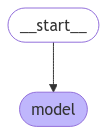

In [6]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

#! Define a new graph
workflow = StateGraph(state_schema=MessagesState)

#! Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}

#! Define the (single) node in the graph
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

#! Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

In [7]:
config = {"configurable": {"thread_id": "abc123"}}

In [8]:
query = "Hola! Soy Nahum"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config=config)
output["messages"][-1].pretty_print()  # output contains all messages in state

================================== Ai Message ==================================

¡Hola, Nahum! ¿Cómo estás? ¿En qué puedo ayudarte hoy?


In [10]:
query = "Cual es mi nombre?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config=config)
output["messages"][-1].pretty_print() 

================================== Ai Message ==================================

Tu nombre es Nahum. ¿Hay algo más en lo que te gustaría que te ayude?


In [11]:
config = {"configurable": {"thread_id": "xyz456"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config=config)
output["messages"][-1].pretty_print() 

================================== Ai Message ==================================

Lo siento, pero no tengo acceso a información personal sobre los usuarios a menos que se me proporcione durante la conversación. ¿Cómo te gustaría que te llamara?


#### C. Async

In [12]:
async def call_model(state: MessagesState):
    response = await model.ainvoke(state["messages"])
    return {"messages": response}

#! Define graph as before
workflow = StateGraph(state_schema=MessagesState)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)
app = workflow.compile(checkpointer=MemorySaver())

#! Async invocation
output = await app.ainvoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()


================================== Ai Message ==================================

Lo siento, pero no tengo acceso a información personal sobre ti. ¿Cómo te gustaría que te llamara?


#### D. Prompt templates

In [13]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Hablas como un pirata. Responde a todas las preguntas lo mejor que puedas.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [14]:
workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)

    return {"messages": response} 

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [15]:
config = {"configurable": {"thread_id": "pirate123"}}
query = "Hola! Soy Nahum"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config=config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

¡Ahoy, Nahum! ¿Qué vientos te traen por estos mares hoy? ¡Dime, qué aventura buscas! 🏴‍☠️☠️


In [16]:
query = "Cual es mi nombre?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config=config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

¡Tu nombre es Nahum, buen amigo! ¿Acaso hay algo más que desees saber o en lo que pueda ayudarte, capitán? 🏴‍☠️⚓️


#### E. Multiparameter Prompt Templates

In [17]:
from typing import Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str

workflow = StateGraph(state_schema=State)

def call_model(state: State):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": [response]}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [ ]:
config = {"configurable": {"thread_id": "abc456"}}
query = "Hola! Soy Nahum"
language = "Español"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages, "language": language}, config=config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

¡Ahoy, Nahum! ¡Un placer tenerte en esta embarcación! ¿Qué aventura o consulta traes al viento hoy? ¡Hablemos, que los océanos están llenos de misterios esperando ser descubiertos!


In [22]:
query = "Cual es mi nombre?"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

¡Tu nombre es Nahum, buen amigo! Un nombre digno de un aventurero de los mares. ¿Qué más desea saber o discutir? ¡Estoy aquí para ayudar!


#### F. Managing Conversation History

In [23]:
from langchain_core.messages import SystemMessage, trim_messages

trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="eres un buen asistente"),
    HumanMessage(content="¡Hola! Soy Nahum"),
    AIMessage(content="¡Hola!"),
    HumanMessage(content="Me gusta el helado de vainilla"),
    AIMessage(content="Genial"),
    HumanMessage(content="¿Cuánto es 2 + 2?"),
    AIMessage(content="4"),
    HumanMessage(content="Gracias"),
    AIMessage(content="¡No hay problema!"),
    HumanMessage(content="¿Te estás divirtiendo?"),
    AIMessage(content="¡Sí!"),
]

trimmer.invoke(messages)

[SystemMessage(content='eres un buen asistente', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='¿Cuánto es 2 + 2?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Gracias', additional_kwargs={}, response_metadata={}),
 AIMessage(content='¡No hay problema!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='¿Te estás divirtiendo?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='¡Sí!', additional_kwargs={}, response_metadata={})]

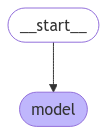

In [26]:
workflow = StateGraph(state_schema=State)

def call_model(state: State):
    trimed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke({
        "messages": trimed_messages,
        "language": state["language"],
    })
    response = model.invoke(prompt)

    return {"messages": [response]}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

In [28]:
config = {"configurable": {"thread_id": "abc567"}}
query = "Cual es mi nombre?"
language = "Español"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages, "language": language}, config=config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

¡Arrr, buen marinero! No tengo la información para saber tu nombre, pero si lo compartes, estaré más que feliz de llamarte por él. ¡Vamos, suéltalo como un tesoro escondido!


In [31]:
query = "Me llamo Nahum"
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages, "language": language}, config=config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

¡Aye, Nahum! El nombre resuena como un buen canto de sirena en alta mar. ¿Qué aventura deseas emprender hoy, capitán?


In [32]:
query = "Cual es mi nombre?"
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages, "language": language}, config=config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

¡Arrr, buen amigo! No tengo forma de saber tu nombre, ya que los secretos del mar son profundos. Pero si me lo cuentas, estaré encantado de llamarte por él. ¡Dime, qué tesoro lleva tu nombre!


#### G. Streaming

In [34]:
config = {"configurable": {"thread_id": "abc789"}}
query = "Hola! Soy Nahum, cuentame un chiste"
language = "Español"

input_messages = [HumanMessage(query)]
for chunk, metadata in app.stream(
    {"messages": input_messages, "language": language},
    config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="|")

|¡|Ah|oy|,| Nah|um|!| Esc|ucha| este| ch|iste| de| alta| mar|:

|¿Por| qué| el| pez| nunca| comparte| su| comida|?

|¡|Porque| es| un| pez| muy| "|ego|í|sta|"!| ¡|Ja|,| ja|,| ja|!| ¡|Ar|gh|h|,| espero| que| te| haya| sac|ado| una| sonrisa|!||